### File Conversion: Geodatabase to GeoJSON
*Purpose*: Conversion of Census Tiger/LINE geodatabases file to compressed GeoJSON files

**Note**
> Best practices for Error and Exception handling not included.
> Please review [appropriate resources](https://docs.python.org/3/tutorial/errors.html) for instructions of code structure.

In [1]:
# !pip install pandas
# !pip install geopandas
# !pip install fiona
# !pip install matplotlib
# !pip install zipfile

In [2]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import os

`out_dir`:  Location of final output directory \
`geodb_fl`: File geodatabase containing [National Sub-State Geography](https://www2.census.gov/geo/tiger/TGRGDB22/tlgdb_2022_a_us_substategeo.gdb.zip) data

In [3]:
out_dir = r"<file-path>/output/"
geodb_fl = r"<file-path>/tlgdb_2021_a_us_substategeo.gdb"

# Print available features
layers = fiona.listlayers(geodb_fl)
for l in layers:
    print("Layer Name: " + l)

Layer Name: Incorporated_Place
Layer Name: County
Layer Name: Census_Designated_Place
Layer Name: Census_Tract
Layer Name: Consolidated_City
Layer Name: County_Subdivision
Layer Name: State
Layer Name: Block_Group


In [4]:
# For each layer in the geodatabase, write to .geojson, then compress (.zip).
# Delete orginal .geojson file.

for l in layers:
    if l == "State":
        layer = gpd.read_file(geodb_fl, layer=l)
        print("Creating .geojson file for: " + l)
        layer.to_file(out_dir + l + ".geojson", driver="GeoJSON")

        print("Creating .zip archive of: " + l)
        with zipfile.ZipFile(out_dir + l + ".zip", compression=zipfile.ZIP_DEFLATED, mode = "w") as zf:
            zf.write(out_dir + l + ".geojson", arcname = l + ".geojson")
        
        print("Removing .geojson file: " + l)
        os.remove(out_dir + l + ".geojson")

Creating .geojson file for: State
Creating .zip archive of: State
Removing .geojson file: State


### Read compressed GeoJSON files and plot

In [5]:
# Create GeoDataFrames from GeoJSON archive files
fl_st = gpd.read_file(out_dir + "State.zip!State.geojson")
fl_cnty = gpd.read_file(out_dir + "County.zip!County.geojson")

In [6]:
# Demonstration of calculating new column in GeoDataFrame
print("## Before calculation ##")
print(fl_cnty.dtypes)
fl_cnty['per_water'] = fl_cnty.AWATER + (fl_cnty.ALAND + fl_cnty.AWATER)
print("## After calculation ##")
print(fl_cnty.dtypes)

## Before calculation ##
COUNTYNS      object
GEOID         object
NAMELSAD      object
CLASSFP       object
FUNCSTAT      object
ALAND        float64
AWATER       float64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object
## After calculation ##
COUNTYNS       object
GEOID          object
NAMELSAD       object
CLASSFP        object
FUNCSTAT       object
ALAND         float64
AWATER        float64
INTPTLAT       object
INTPTLON       object
geometry     geometry
per_water     float64
dtype: object


In [7]:
# Querying and subsetting GeoDataFrames
srnd_st = fl_st.query("STUSPS in  ('OH','PA','IN','WV','KY')")
oh_cnty = fl_cnty[fl_cnty.GEOID.str.startswith('39')]

<AxesSubplot: >

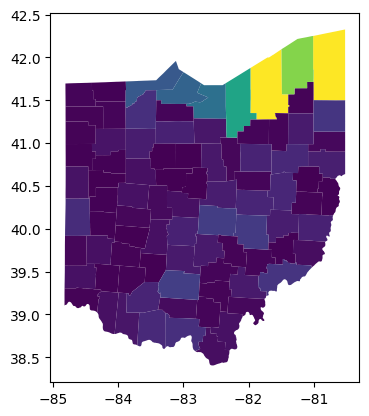

In [8]:
# Plot Ohio counties symbolized on county's area percent water
oh_cnty.plot(column='per_water')

<AxesSubplot: >

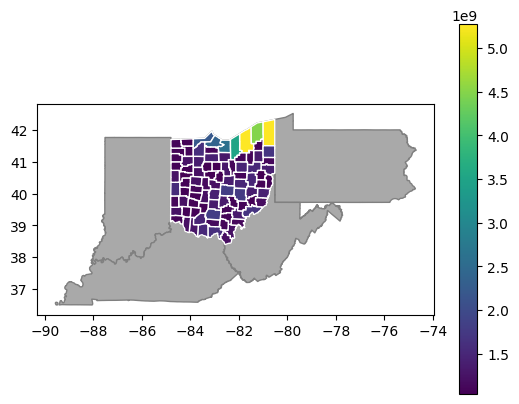

In [9]:
# Add legend and surrounding states for more context and completeness
base = srnd_st.plot(edgecolor='gray', color='darkgray')
oh_cnty.plot(ax=base, edgecolor='white',column='per_water', legend = True)